In [37]:
import numpy as np
import pmdarima as pm
from pmdarima import pipeline, preprocessing as ppc, arima
from matplotlib import pyplot as plt

In [38]:
# Load the data and split it into separate pieces
data = pm.datasets.load_wineind()
train, test = data[:150], data[150:]

In [40]:
test.shape

(26,)

In [6]:
# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=12)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              transparams=False,
                              suppress_warnings=True))
])

In [7]:
pipe.fit(train)
print("Model fit:")
print(pipe)

Fit ARIMA: order=(2, 1, 2); AIC=2730.309, BIC=2784.380, Fit time=1.046 seconds
Fit ARIMA: order=(0, 1, 0); AIC=2844.584, BIC=2886.639, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2804.782, BIC=2849.841, Fit time=0.262 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2746.934, BIC=2791.993, Fit time=0.376 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2746.086, BIC=2797.153, Fit time=0.439 seconds
Fit ARIMA: order=(3, 1, 2); AIC=2735.853, BIC=2792.928, Fit time=0.513 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2743.483, BIC=2794.550, Fit time=1.011 seconds
Fit ARIMA: order=(2, 1, 3); AIC=2731.638, BIC=2788.713, Fit time=1.625 seconds
Fit ARIMA: order=(1, 1, 1); AIC=2746.350, BIC=2794.413, Fit time=0.796 seconds
Fit ARIMA: order=(3, 1, 3); AIC=2728.631, BIC=2788.710, Fit time=3.487 seconds
Fit ARIMA: order=(4, 1, 3); AIC=2735.867, BIC=2798.950, Fit time=0.532 seconds
Fit ARIMA: order=(3, 1, 4); AIC=2736.134, BIC=2799.217, Fit time=0.899 seconds
Fit ARIMA: order=(4, 1, 4); AIC=2733.517, BIC=2799.6

In [8]:
# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=10, return_conf_int=True)
print("\nForecasts:")
print(preds)


Forecasts:
[28928.72325035 29733.25698831 25205.1302632  27009.46349159
 31885.13376527 36861.2812549  18979.80225611 22062.82158555
 25094.85190292 25862.90544153]


(0, 176)

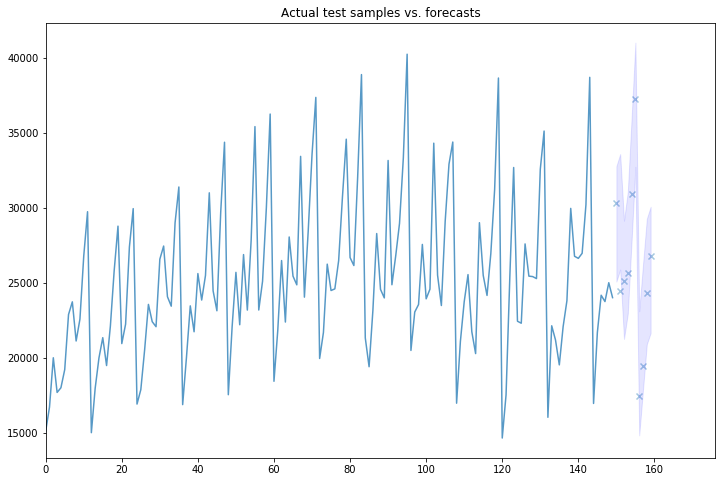

In [24]:
# Let's take a look at the actual vs. the predicted values:
fig = plt.figure(figsize=(12, 8))

n_train = train.shape[0]
x = np.arange(n_train + preds.shape[0])
plt.plot(x[:n_train], train, alpha=0.75)
# axes[0].scatter(x[n_train:], preds, alpha=0.4, marker='o')
plt.scatter(x[n_train:], test[:preds.shape[0]], alpha=0.4, marker='x')
plt.fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

plt.title('Actual test samples vs. forecasts')
plt.xlim((0, data.shape[0]))


In [36]:
n_train
test.shape

(26,)

In [25]:
# We can also call `update` directly on the pipeline object, which will update
# the intermittent transformers, where necessary:
newly_observed, still_test = test[:15], test[15:]
pipe.update(newly_observed, maxiter=10)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 3),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=False, trend=None, with_intercept=True)

In [26]:
# Calling predict will now predict from newly observed values
new_preds = pipe.predict(still_test.shape[0])
print(new_preds)

[27870.58244136 31591.77913719 36854.33491411 18737.25887992
 21827.93354925 24735.45525782 25476.13463653 24835.08377019
 24743.59941862 29629.00374512 30162.13118068]


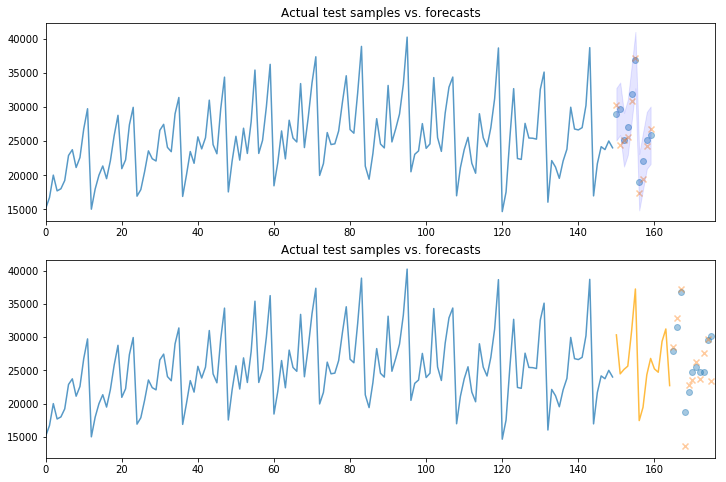

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(x[:n_train], train, alpha=0.75)
axes[0].scatter(x[n_train:], preds, alpha=0.4, marker='o')
axes[0].scatter(x[n_train:], test[:preds.shape[0]], alpha=0.4, marker='x')
axes[0].fill_between(x[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
axes[0].set_title('Actual test samples vs. forecasts')
axes[0].set_xlim((0, data.shape[0]))

x2 = np.arange(data.shape[0])
n_trained_on = n_train + newly_observed.shape[0]

axes[1].plot(x2[:n_train], train, alpha=0.75)
axes[1].plot(x2[n_train: n_trained_on], newly_observed, alpha=0.75, c='orange')
axes[1].scatter(x2[n_trained_on:], new_preds, alpha=0.4, marker='o')
axes[1].scatter(x2[n_trained_on:], still_test, alpha=0.4, marker='x')
axes[1].set_title('Actual test samples vs. forecasts')
axes[1].set_xlim((0, data.shape[0]))

plt.show()